# Scope of this NoteBook:

In this notebook we study different techniques to perform time series analysis.
The main usecase we have here is to predict the closing price of Apple given the previous X prices.
We will compare different models, different hyperparameters and we willalso compare different observables.

The datacleaning and gathering and the LSTM model architecture is done following [link](https://www.youtube.com/watch?v=QIUxPv5PJOY), the exploration of the different batch sizes, the comparison with simpler model and with Fourier transforms and the Returns studies have been done by myself.

I would like to aknowledge useful discussions with P Mattioli and G Minneci.

In [1]:
import numpy as np
import pandas_datareader as web
import pandas as pd
import matplotlib.pyplot as plt
import math

/home/lorenzo/Documents/learning/TimeSeriesTutorial/.LSTM/lib/python3.6/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


### Downloading the data

We will use DataReader (provided by PanDas) to download the data.
We will choose the followings:
1. Apple prices (AAPL)
2. Yahoo finance as a source
3. The starting point as first of january 2012
4. The final point as December 17th 2019

In [2]:
df = web.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2019-12-17')

ConnectionError: HTTPSConnectionPool(host='finance.yahoo.com', port=443): Max retries exceeded with url: /quote/AAPL/history?period1=1325386800&period2=1576637999&interval=1d&frequency=1d&filter=history (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x7f12cd65fb38>: Failed to establish a new connection: [Errno -2] Name or service not known',))

In [3]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,58.928570,58.428570,58.485714,58.747143,75555200.0,50.994907
2012-01-04,59.240002,58.468571,58.571430,59.062859,65005500.0,51.268970
2012-01-05,59.792858,58.952858,59.278572,59.718571,67817400.0,51.838169
2012-01-06,60.392857,59.888573,59.967144,60.342857,79573200.0,52.380054
2012-01-09,61.107143,60.192856,60.785713,60.247143,98506100.0,52.296970


In [4]:
df.describe()

,High,Low,Open,Close,Volume,Adj Close
count,2003.000000,2003.000000,2003.000000,2003.000000,2.003000e+03,2003.000000
mean,127.194100,124.954538,126.079166,126.109797,5.960691e+07,119.389611
std,50.028310,49.234509,49.592770,49.679272,4.688887e+07,51.745687
min,57.085712,55.014286,55.424286,55.790001,1.136200e+07,49.142811
25%,86.649998,84.915001,85.766430,85.971428,2.760790e+07,75.313698
50%,114.019997,111.660004,112.820000,112.919998,4.369990e+07,105.513168
75%,165.939995,162.125000,163.845001,163.970001,7.482090e+07,158.767662
max,281.769989,278.799988,279.570007,280.410004,3.765300e+08,279.746094


### Plotting the data

Before to study any model, we will plot the data.
We are interested in the closing prices of the  stock represented by the column 'Close'

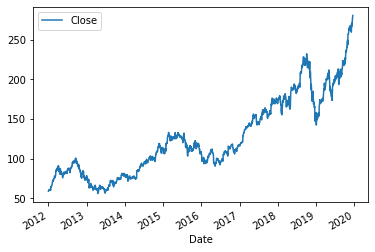

In [5]:
df.plot(y = 'Close')

### Isolate the data

We want to predict the closing prices given the history of the same quantity.
We can then isolate them creating a new dataframe.
We convert then it to numpy

In [7]:
df_cp = pd.DataFrame(df['Close'])

In [8]:
df_cp

,Close
Date,
2012-01-03,58.747143
2012-01-04,59.062859
2012-01-05,59.718571
2012-01-06,60.342857
2012-01-09,60.247143
...,...
2019-12-11,270.769989
2019-12-12,271.459991
2019-12-13,275.149994


In [10]:
data = df_cp.to_numpy()

In [11]:
data

array([[ 58.74714279],
       [ 59.06285858],
       [ 59.71857071],
       ...,
       [275.1499939 ],
       [279.85998535],
       [280.41000366]])

## Train Test Split

It is now time to prepare to train the model, this means that we need to split out data into *train* and *test* sets.
We create a helper function to perform this without shuffling the data, we want to preserve our time series and use the data before a certain date to tain our model and then to use the data after that date to test it in order to observe how much it can look into the future.

In [12]:
def train_test_split(dataset, percentage=0.8):
    return dataset[:math.ceil(len(dataset)*percentage)], dataset[math.ceil(len(dataset)*percentage):] 

In [13]:
train_dataset, test_dataset = train_test_split(data)

In [14]:
print(len(train_dataset),
len(test_dataset),
len(data))

1603 400 2003


## Scale the data

Many models require their inputs to be properly normalized, machine learning models are no exception.
We are going to use the sklearn MinMaxScaler to normalize the interval setting the minimum value to zero and the maximum value to 1, we are not imposing any statistics to the data as we would do using a norma scaler or something similar.

It is important to notice that the normalization is done just on the *train* set, if we do it on the entire dataset we are going to pour some of the information of the *test* into the *train*, which is something we do not want.

**NB** The video I cited in the beginning was using the entire dataset to normalize its data, making there a quite big mistake.

In [15]:
from sklearn.preprocessing import MinMaxScaler

In [16]:
# We then define the scaler and we apply it
scaler = MinMaxScaler()
scaler.fit(train_dataset)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [17]:
# We create a new scaled dataset
scaled_train = scaler.transform(train_dataset)

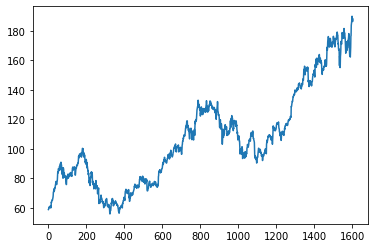

In [18]:
plt.plot(train_dataset)

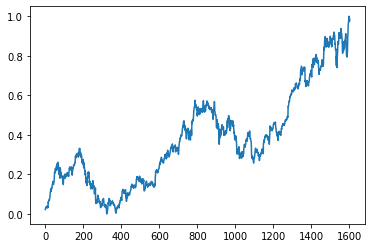

In [19]:
# We observe how it is  in between0 and 1
plt.plot(scaled_train)

In [20]:
# We now rescale the test
scaled_test = scaler.transform(test_dataset)

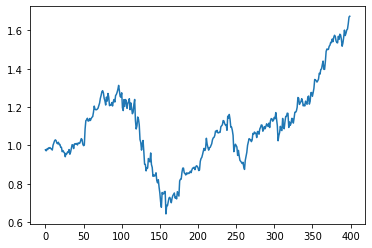

In [21]:
# We plot it
plt.plot(scaled_test)

# LSTM in Keras

One of the most known and widely used models to perform time series analysis is the Long Short Term Memory.
The success of this model is due to its capacity of keeping memory of both long and short term dependencies, and also to avoid the vanishing gradient problem.
We are going to use the model to extract informations and predict the next prices, the scheme of the model is the following:
1. 2 LSTM layers are used to extract features from the time series, each of them has a hidden dimension of 50
2. The features are the run through a dense layer, which compresses the information to 25
3. The final result is predicted from the prevousily compressed features

The model is trained optimizing the $L_2$ losses on the target value which we feed in to supervise the learning.
The optimizer used is ADAM and we train for a total of 20 epochs.

## Creation of the  training data

We need now to rewrite the dataset in a way that it is suitable to train our model.

General models for sequences analysis require their input to be something like:
*$ \left[ \text{Batch size}, \text{Sequence Length}, \text{Input Features} \right] $*

We are going to manipulate the dataset to be rewritten as:
*$\left[ \text{Elements in the Dataset}, \text{Values} \right] \rightarrow \left[ \text{Elements in the dataset} - \text{Seq}, \text{Seq}, 1 \right]$*

for the input. The output is going to be rewritten as:

*$\left[ \text{Elements in the dataset} - \text{Seq}, \text{Seq}, 1 \right]$*

In [23]:
def create_training_data(train_dataset, Seq):
    final_input = []
    result = []
    for t in range(Seq, len(train_dataset)):
#         at each time t we select the previous Seq values and we get as result t
        final_input.append(train_dataset[t-Seq:t])
        result.append(train_dataset[t])
    return np.asarray(final_input), np.asarray(result)

In [24]:
train_data, train_target = create_training_data(scaled_train, 60)

In [26]:
train_data.shape

(1543, 60, 1)

In [27]:
train_target.shape

(1543, 1)

In [28]:
import keras

Using TensorFlow backend.


### The model

In [30]:
model = keras.Sequential()

In [31]:
model.add(keras.layers.LSTM(50, return_sequences=True, input_shape = (60, 1)))

In [32]:
model.add(keras.layers.LSTM(50, return_sequences=False))

In [33]:
model.add(keras.layers.Dense(25, activation = 'relu'))

In [34]:
model.add(keras.layers.Dense(1))

### The Optimizer and the Losses

In [35]:
model.compile(optimizer='adam', loss = 'mse')

### The training loop

We are going to execute the training with a small batch size, 4.

Larger values of the batch size, 128 for example, have resulted in the model averaging the time series, making it worst when it comes to performances.

In [36]:
model.fit(train_data, train_target, batch_size=4, epochs=20)

Epoch 1/20
1543/1543 [==============================] - 28s 18ms/step - loss: 0.0030
Epoch 2/20
1543/1543 [==============================] - 18s 12ms/step - loss: 9.0866e-04
Epoch 3/20
1543/1543 [==============================] - 19s 12ms/step - loss: 7.9009e-04
Epoch 4/20
1543/1543 [==============================] - 24s 16ms/step - loss: 6.0020e-04
Epoch 5/20
1543/1543 [==============================] - 20s 13ms/step - loss: 5.6335e-04
Epoch 6/20
1543/1543 [==============================] - 24s 16ms/step - loss: 4.7675e-04
Epoch 7/20
1543/1543 [==============================] - 27s 17ms/step - loss: 3.5713e-04
Epoch 8/20
1543/1543 [==============================] - 30s 19ms/step - loss: 3.2791e-04
Epoch 9/20
1543/1543 [==============================] - 20s 13ms/step - loss: 3.2336e-04
Epoch 10/20
1543/1543 [==============================] - 20s 13ms/step - loss: 4.0447e-04
Epoch 11/20
1543/1543 [==============================] - 23s 15ms/step - loss: 3.0018e-04
Epoch 12/20
1543/1543 [

### Testing the model

The model trained up to now is then used to extract predictions about its performances on the test dataset.

We create the test input and target data as we did for the train data, the same Sequence length has to be used.

We can then extract the predictions of our model given the inputs of the test data and we can finally compre them and plot them together.

In [38]:
test_data, test_target = create_training_data(scaled_test, 60)

In [39]:
model.evaluate(x=test_data, y=test_target)

340/340 [==============================] - 0s 998us/step


0.0008878697654889787

In [40]:
prediction = model.predict(test_data)

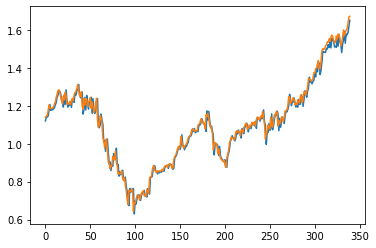

In [41]:
plt.plot(prediction)
plt.plot(test_target)
plt.show()

### Un-Normalize the data

The data presented before are still using the noramlized input, we can use the scaler we defined before to un-normalize them and see the predictions in the correct scale.

In [43]:
prediction = scaler.inverse_transform(prediction)

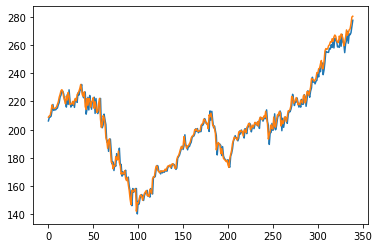

In [44]:
plt.plot(prediction)
plt.plot(test_dataset[60:])
plt.show()

# A very simple model

We can then compare our results for the time series against the simpler model possible.
In order to  predict the value of the point $ x\left[ t+1 \right] $ we use a linear interpolation of the previous two:
$ x\left[ t+1 \right] = 2 x\left[ t \right] - x\left[ t-1 \right]$.
This model will provide a baseline we would run against using our LSTM model build in Keras.

In [45]:
# Another simple model
def model(seq):
#     We simply use a stupid regression
#     x[t+1] = 2*x[t]-x[t-1]
    result = []
    for i in range(2, len(seq)):
        result.append(2.*seq[i-1]-seq[i-2])
    return np.asarray(result)

In [46]:
simple_pred = model(test_dataset)

In [47]:
print(len(simple_pred))
print(len(test_dataset[2:]))

398
398


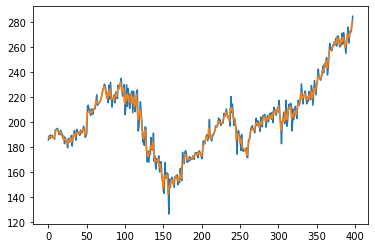

In [48]:
plt.plot(simple_pred)
plt.plot(test_dataset[2:])
plt.show()

### Comparing the models

We have now two models, we want now to understand which of them performs better after training.

Clearly, we expect our simple model to perform the worst, but we need a quantitative way to say what is best and what is worst.
We then use the R2 score, again provided by the scikitlearn library, to compute the score on the test set.

In [ ]:
from sklearn.metrics import r2_score

In [ ]:
r2_score(test_dataset[2:], simple_pred)

In [ ]:
r2_score(test_dataset[60:], prediction)

## Fourier Series

We can now use another way to predict the time evolution of our time series: Fourier Series.

The idea is to use the training set to compute the Fourier coefficients of out signal, then we will use these Fourier coefficients to perform interpolation on the test signal and see how accuracte this model is.

In [49]:
import scipy

In [50]:
# We compute the Fourier series
coefficients = np.fft.fft(scaled_train.reshape(len(scaled_train)))

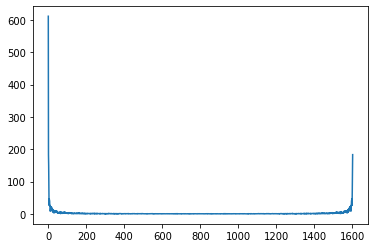

In [51]:
plt.plot(np.absolute(coefficients))

In [52]:
def filter_and_rescale(coef, low_filter = 0., high_filter = 0.):
    coef[coef<0.5] = 0
    low_lim = int(len(coef)*low_filter)
    high_lim = int(len(coef)*(1-high_filter))
    result = np.concatenate((np.zeros(low_filter), coef[low_lim:high_lim], np.zeros(len(coef)-high_lim)))
    assert len(result) == len(coef)
    return result

In [53]:
fft = filter_and_rescale(coefficients, low_filter=0, high_filter=0.)

In [54]:
len(fft)

1603

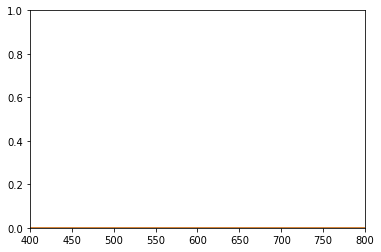

In [55]:
plt.xlim([400,800])
plt.ylim([0,1])
plt.plot(np.absolute(coefficients))
plt.plot(np.absolute(fft))
plt.show()

In [56]:
fft_pred = np.fft.ifft(coefficients, len(scaled_train))
fft_filter = np.fft.irfft(fft, len(scaled_train))

In [57]:
fft_pred = np.fft.irfft(coefficients, len(scaled_train)+len(scaled_test))
fft_filter = np.fft.irfft(np.pad(fft,(0, len(scaled_test)//2)))

In [58]:
def time_evolution(coeff, init_time):
    freq = np.fft.fftfreq(coeff.size, d=1)
    coeff  = np.multiply(coeff, np.exp(1.0j*freq*init_time))
    return coeff

In [59]:
t_evolved = time_evolution(fft, 0)

In [60]:
evo = np.fft.ifft(t_evolved, len(scaled_train))

/home/lorenzo/Documents/learning/TimeSeriesTutorial/.LSTM/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/lorenzo/Documents/learning/TimeSeriesTutorial/.LSTM/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


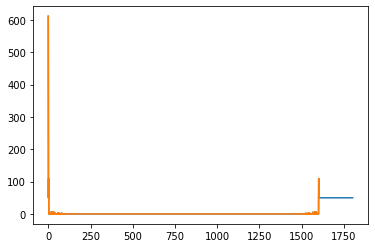

In [61]:
plt.plot(np.pad(fft, (0, len(scaled_test)//2), mode = 'edge'))
plt.plot(fft)

In [62]:
print(len(evo))
print(len(scaled_train))
print(len(scaled_test))

1603
1603
400


/home/lorenzo/Documents/learning/TimeSeriesTutorial/.LSTM/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


[]

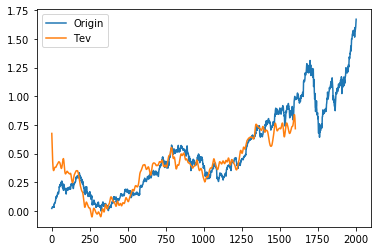

In [63]:
plt.plot(np.concatenate((scaled_train,scaled_test)), label = 'Origin')
plt.plot(evo, label = 'Tev')
# plt.plot(scaled_train, label = 'Orig')
# plt.plot(np.absolute(fft_pred))
# plt.plot(fft_pred)
plt.legend()
plt.plot()

### Returns

We use the models we have derived before, the simple and the LSTM, to predict the returns, defined as

*$
f(x) = \frac{x[t+1]-x[t]}{x[t]}
$*

We start creating an helper function to compute  the returns starting from the closing prices.

In [64]:
def compute_return(closing):
    m = np.diff(closing, axis = 0)
    return m/closing[:-1]

In [65]:
predicted_returns = compute_return(prediction)

In [66]:
true_returns = compute_return(test_dataset[60:])

In [67]:
predicted_returns.reshape(340,1,1)

ValueError: cannot reshape array of size 339 into shape (340,1,1)

In [ ]:
len(predicted_returns)

In [ ]:
true_returns.shape

In [ ]:
r2_score(true_returns, predicted_returns)

In [ ]:
plt.plot(true_returns)
plt.plot(predicted_returns)
plt.show()

In [ ]:
def filter(x, w):
    df = pd.DataFrame(x)
    df = df.rolling(w).mean()
    df = df.dropna()
    return df.to_numpy()

In [ ]:
filtered_test = filter(test_dataset[60:], 10)

In [ ]:
len(filtered_test)

In [ ]:
plt.plot(prediction[10:])
plt.plot(filtered_test)
plt.show()

In [ ]:
true_returns = compute_return(filtered_test)

In [ ]:
plt.plot(true_returns)
plt.plot(predicted_returns[9:])
plt.show()

In [ ]:
r2_score(true_returns, predicted_returns[9:])

In [ ]:
simple_returns  = compute_return(simple_pred)

In [ ]:
true_returns = compute_return(test_dataset)
r2_score(true_returns[2:], simple_returns)

In [ ]:
# plt.plot(true_returns[2:])
# plt.plot(simple_returns)
plt.plot(np.abs(simple_returns-true_returns[2:]))
plt.show()

In [ ]:
zero_model = np.zeros(len(test_dataset))

In [ ]:
r2_score(true_returns, zero_model[1:])